# Machine Learning Demonstration: Predicting Employee Churn 
Prepared by Nick Freeman, PhD (but inspired by many others).

This notebook considers the problem of predicting employee churn for the purpose of demonstrating several machine learning techniques in Python. Employee churn refers to the turnover in an organization's staff as existing employees leave and new ones are hired. The churn rate is typically calculates as the percent of employees leaving the company over some specified time period. Although some staff turnover is inevitable, a high rate of churn is costly because of the associated costs of hiring and training. Moreover, it can take several months for a new higher to acclimate to a new position, and longer before the company realizes any return on their hiring investments. If an organization can predict the attributes that may cause an employee to leave, interventions may be planned to reduce churn.

The following code block imports some initial libraries that we will use for our analysis.

In [1]:
import pandas as pd 

import numpy as np

import matplotlib.pyplot as plt

import seaborn as sns

from ipywidgets import interact

We assume that the company has historical data that was gathered from employee surveys. The data (which was modified from that used in the tutorial available at https://www.datacamp.com/community/tutorials/predicting-employee-churn-python) includes the following fields:

- `satisfaction_level`: the employee's reported satisfaction with their job (ranges from 0 to 100),
- `last_evaluation`: the employees last performance evaluation score, (ranges from 0 to 100),
- `number_of_projects`: the number of projects assigned to the employee,
- `average_monthly_hours`: average number of hours worked by the employee during a month,
- `years_with_company`: the number of years the employee has been with the company,
- `involved_in_accident`: 0 or 1 (no or yes) to indicate whether or not the employee has been involved in an accident at work,
- `promoted_last_5_years`: 0 or 1 (no or yes) to indicate whether or not the employee was promoted within the lat 5 years,
- `department`: the employee's working department/division.
- `salary_level`: the employee's salary level (low, medium, or high),
- `left_company`: 0 or 1 (no or yes) to indicate whether or not the employee left the company.

The following code block reads in the data, stores the data in a Pandas `DataFrame` object named `data`, and prints the first 5 rows of the `data` object.

In [2]:
data = pd.read_csv('data/HR_comma_sep.csv')
data.head()

,satisfaction_level,last_evaluation,number_of_projects,average_monthly_hours,years_with_company,involved_in_accident,left_company,promoted_last_5_years,department,salary_level
0,38.0,53.0,2,157,3,0,1,0,sales,low
1,80.0,86.0,5,262,6,0,1,0,sales,medium
2,11.0,88.0,7,272,4,0,1,0,sales,medium
3,72.0,87.0,5,223,5,0,1,0,sales,low
4,37.0,52.0,2,159,3,0,1,0,sales,low


The following code block uses Pandas `info()` method to provide information on the number and types of information included in each column of the dataset.

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14999 entries, 0 to 14998
Data columns (total 10 columns):
satisfaction_level       14999 non-null float64
last_evaluation          14999 non-null float64
number_of_projects       14999 non-null int64
average_monthly_hours    14999 non-null int64
years_with_company       14999 non-null int64
involved_in_accident     14999 non-null int64
left_company             14999 non-null int64
promoted_last_5_years    14999 non-null int64
department               14999 non-null object
salary_level             14999 non-null object
dtypes: float64(2), int64(6), object(2)
memory usage: 1.1+ MB


The output shows that the dataset has 14,999 samples and 10 attributes (6 integer, 2 float, and 2 objects). No variable column has null/missing values. 

We are interested in developing models that can correctly predict values in the `left_company` column. The following code block uses Pandas `groupby` method to find the mean values of the numeric attributes for employees that have either left or stayed with the company.

In [4]:
data.groupby('left_company').mean()

,satisfaction_level,last_evaluation,number_of_projects,average_monthly_hours,years_with_company,involved_in_accident,promoted_last_5_years
left_company,,,,,,,
0,66.680959,71.547340,3.786664,199.060203,3.380032,0.175009,0.026251
1,44.009801,71.811257,3.855503,207.419210,3.876505,0.047326,0.005321


The previous output suggests that employees that have left the company had a lower mean satisfaction level, worked more hours each month, on average, and had a lower promotion rate. However, they were also less likely to be involved in an accident and are similar to employees that stayed with the comapny in terms of number of projects and years with the company. 

The following code block defines an interactive plot that allows you to easily investigate differences in the number of employees that stay or leave as the various attributes vary.

In [5]:
attribute_columns = ['satisfaction_level', 'last_evaluation', 'number_of_projects',
                     'average_monthly_hours', 'years_with_company', 'involved_in_accident', 'promoted_last_5_years', 'department', 'salary_level']

@interact(attribute = attribute_columns)

def interactive_spend_analysis(attribute = attribute_columns[0]):
    
    data_copy = data.copy()
    data_copy['satisfaction_level'] = pd.cut(data_copy['satisfaction_level'], [i*10 for i in range(11)])
    data_copy['last_evaluation'] = pd.cut(data_copy['last_evaluation'], [i*10 for i in range(11)])
    data_copy['average_monthly_hours'] = pd.cut(data_copy['average_monthly_hours'], [i*25 for i in range(3,14)])
    
    fig, ax = plt.subplots(figsize=(12, 6))
    sns.countplot(x = attribute, 
                  data = data_copy, 
                  hue = 'left_company', 
                  ax = ax,
                  edgecolor = 'k')
    plt.xticks(rotation = 45, fontsize = 14)
    plt.yticks(fontsize = 14)
    ax.set_xlabel(attribute, fontsize = 16)
    ax.set_ylabel('Count', fontsize = 16)
    plt.legend(title ='left_company',fontsize = 16)
    
    plt.show()

interactive(children=(Dropdown(description='attribute', options=('satisfaction_level', 'last_evaluation', 'num…

We will now turn our attention towards preparing the data for our machine learning analysis. The machine learning algorithms that we will consider require numerical input data. So, we need to develop a numerical representation for the categorical data contained in the `department` and `salary_level` columns. The following code block uses Pandas `get_dummies()` method for `DataFrame` objects to generate a binary representation for these columns. The process that we use is commonly referred to as *one hot encoding*.

In [6]:
data = pd.concat([data, pd.get_dummies(data['department'])], axis=1)
data = pd.concat([data, pd.get_dummies(data['salary_level'])], axis=1)

data.columns = ['satisfaction_level', 'last_evaluation', 'number_of_projects',
                'average_monthly_hours', 'years_with_company', 'involved_in_accident',
                'left_company', 'promoted_last_5_years', 'department', 'salary_level',
                'IT', 'RandD', 'accounting', 'hr', 'management', 'marketing',
                'product_mng', 'sales', 'support', 'technical', 
                'salary_high', 'salary_low', 'salary_medium']

data.head()

,satisfaction_level,last_evaluation,number_of_projects,average_monthly_hours,years_with_company,involved_in_accident,left_company,promoted_last_5_years,department,salary_level,...,hr,management,marketing,product_mng,sales,support,technical,salary_high,salary_low,salary_medium
0,38.0,53.0,2,157,3,0,1,0,sales,low,...,0,0,0,0,1,0,0,0,1,0
1,80.0,86.0,5,262,6,0,1,0,sales,medium,...,0,0,0,0,1,0,0,0,0,1
2,11.0,88.0,7,272,4,0,1,0,sales,medium,...,0,0,0,0,1,0,0,0,0,1
3,72.0,87.0,5,223,5,0,1,0,sales,low,...,0,0,0,0,1,0,0,0,1,0
4,37.0,52.0,2,159,3,0,1,0,sales,low,...,0,0,0,0,1,0,0,0,1,0


The following code block defines the set of columns of the `data` object that we will pass to our machine learning algorithms as features. The algorithms will attempt to learn patterns of these features that explain the target variable, which for our problem is the value in the `left_company` column.

In [7]:
features = ['satisfaction_level', 'last_evaluation', 'number_of_projects',
            'average_monthly_hours', 'years_with_company', 'involved_in_accident',
            'promoted_last_5_years', 'IT', 'RandD', 'accounting', 
            'hr', 'management', 'marketing', 'product_mng', 'sales', 'support', 'technical',
            'salary_high', 'salary_low', 'salary_medium']

target = 'left_company'

X = data[features]
y = data[target]

The following code block splits the dataset into two parts, training and testing datasets. The machine learning algorithms will use the training dataset to attempt to learn the feature patterns that affect the target, and the testing dataset will be used to investigate the accuracy of the learned models. We specify that 70% of the data be used for training and the remianing 30% be used for testing.

In [8]:
# Import train_test_split function
from sklearn.model_selection import train_test_split

# Split dataset into training set and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)  # 70% training and 30% test

# Logistic Regression

In this section, we show how to define a logistic regression model for our prediction problem. In statistics, the logistic model (or logit model) is a widely used statistical model that, in its basic form, uses a logistic function to model a binary dependent variable; many more complex extensions exist. In regression analysis, logistic regression (or logit regression) is estimating the parameters of a logistic model; it is a form of binomial regression. Mathematically, a binary logistic model has a dependent variable with two possible values, such as pass/fail, win/lose, alive/dead or healthy/sick; these are represented by an indicator variable, where the two values are labeled "0" and "1". In the logistic model, the log-odds (the logarithm of the odds) for the value labeled "1" is a linear combination of one or more independent variables ("predictors"); the independent variables can each be a binary variable (two classes, coded by an indicator variable) or a continuous variable (any real value). The corresponding probability of the value labeled "1" can vary between 0 (certainly the value "0") and 1 (certainly the value "1"), hence the labeling; the function that converts log-odds to probability is the logistic function, hence the name.

The following code block uses the scikit-learn package to define a logistic regression model, fit the model to our training data, and use the fitted model to make predictions for the instances included in the testing dataset.

In [9]:
from sklearn.linear_model import LogisticRegression

clf = LogisticRegression(solver = 'newton-cg')
clf = clf.fit(X_train, y_train)
predictions = clf.predict(X_test)
score = clf.score(X_test, y_test)
print(f'The logistic regression model achieves an accuracy of {np.round(100*score, 2)}%')

The logistic regression model achieves an accuracy of 78.62%


The output of the previous code block suggests that our logistic regression model is able to correctly predict whether or not an employee will leave for approximately 78.62% of the test instances. 

The following code block defines a function for generating a confusion matrix for the predictions. The cofusion matric provides additional information regarding the type of errors made by a machine learning model (i.e., false positives or false negatives).

In [10]:
def plot_confusion_matrix(cm):
    
    f, ax = plt.subplots(figsize=(8, 8))

    ax = sns.heatmap(cm, annot=True,
                     fmt=".0f", 
                     square = True,
                     linecolor='k',
                     annot_kws={"size": 20})
    for _, spine in ax.spines.items():
        spine.set_visible(True)

    plt.xticks(fontsize = 18)    
    plt.yticks(fontsize = 18) 
    plt.ylabel('left_job actual', fontsize = 18);
    plt.xlabel('left_job predicted', fontsize = 18);
    cax = plt.gcf().axes[-1]
    cax.tick_params(labelsize = 14)
    plt.show()

The following code block uses our function to generate the confusion matrix for the logistic regression model. 

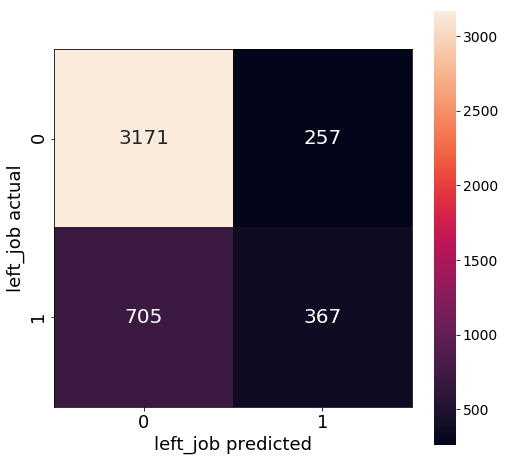

In [11]:
from sklearn import metrics

cm = metrics.confusion_matrix(y_test, predictions)

plot_confusion_matrix(cm)

# Decision Tree

Decision Tree models divide the feature space into sub-parts by identifying threshold feature values that result in good separation of the target variable for training instances. The following code block defines a decision tree model, fits the model to the training data, and uses the fitted model to predict the target variable for the instances in the testing dataset.

In [12]:
from sklearn import tree
clf = tree.DecisionTreeClassifier()
clf = clf.fit(X_train, y_train)
predictions = clf.predict(X_test)
score = clf.score(X_test, y_test)
print(f'The decision tree model achieves an accuracy of {np.round(100*score, 2)}%')

The decision tree model achieves an accuracy of 97.38%


The decision tree model offers a dramatic imporvement in accuracy when compared to the logistic regression model. In particular, the decision tree model offers an accuracy improvement of nearly 20%, correctly predicting whether or not an employee leaves for approximately 97.5% of the test instances. The confusion matrix for the decision tree predictions follows.

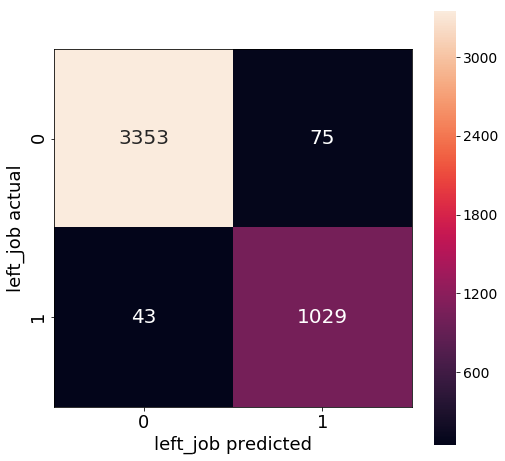

In [13]:
cm = metrics.confusion_matrix(y_test, predictions)

plot_confusion_matrix(cm)

The confusion matrix shows the nature of the improvements in prediction. Of particular interest, we note that the model only makes 43 incorrect predictions on the 1,072 instances where the associated employee actually left the company. The following plot uses the `feature_importances_` attribute of the model to show which features have the larget impact on the classification.

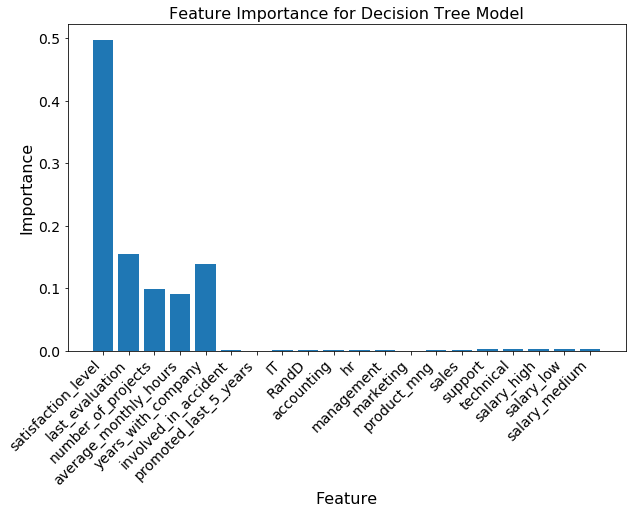

In [14]:
x_vals = [i for i in range(len(clf.feature_importances_))]

fig, ax = plt.subplots(figsize = (10,6))

ax.bar(x_vals, clf.feature_importances_)
ax.set_xticks(x_vals)
ax.set_xticklabels(features, ha='right') 
    
plt.xticks(rotation = 45, fontsize = 14)
plt.yticks(fontsize = 14)
ax.set_xlabel('Feature', fontsize = 16)
ax.set_ylabel('Importance', fontsize = 16)
ax.set_title('Feature Importance for Decision Tree Model', fontsize = 16)

plt.show()

# Random Forest

In this section, we consider a random forest classification model. Random forests construct a specified number of decision trees and outputs the mode class of the individual trees. By *ensembling* several decision trees, random forests are very resilient against overfitting to the training set. The following code block defines a random forest model that consists of 100 decision trees, fits the model to the training data, and uses the fitted model to predict the target variable for the instances in the testing dataset.

In [15]:
from sklearn.ensemble import RandomForestClassifier

clf = RandomForestClassifier(n_estimators = 100, random_state=0)
clf = clf.fit(X_train, y_train)
predictions = clf.predict(X_test)
score = clf.score(X_test, y_test)
print(f'The logistic regression model achieves an accuracy of {np.round(100*score, 2)}%')

The logistic regression model achieves an accuracy of 98.67%


The following code block prints the confusion matrix for the decision tree model.

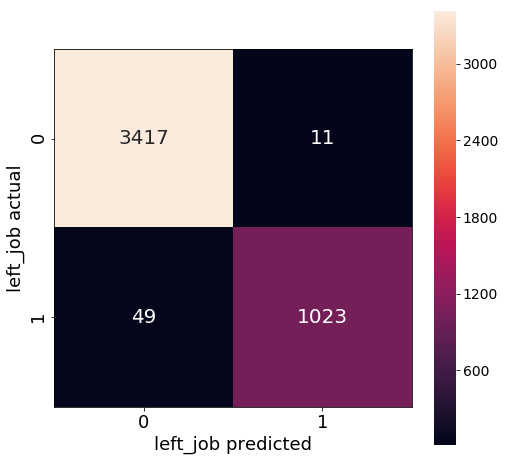

In [16]:
cm = metrics.confusion_matrix(y_test, predictions)

plot_confusion_matrix(cm)

The following plot uses the `feature_importances_` attribute of the model to show which features have the larget impact on the classification.

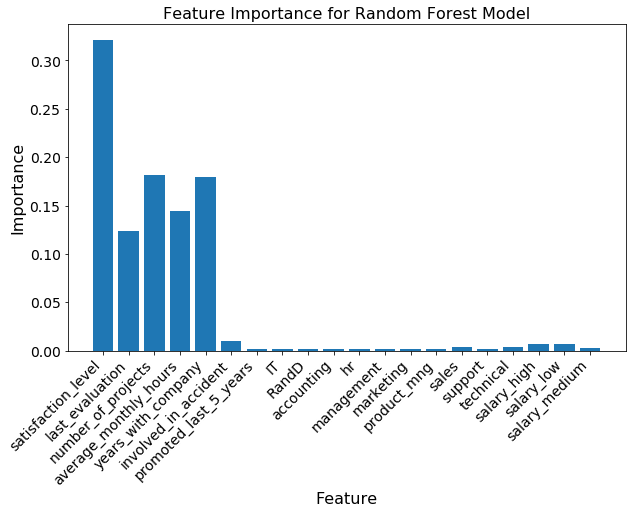

In [17]:
x_vals = [i for i in range(len(clf.feature_importances_))]

fig, ax = plt.subplots(figsize = (10,6))

ax.bar(x_vals, clf.feature_importances_)
ax.set_xticks(x_vals)
ax.set_xticklabels(features, ha='right') 
#for tick in ax.get_xticklabels():
#    tick.set_rotation(60)
    
plt.xticks(rotation = 45, fontsize = 14)
plt.yticks(fontsize = 14)
ax.set_xlabel('Feature', fontsize = 16)
ax.set_ylabel('Importance', fontsize = 16)
ax.set_title('Feature Importance for Random Forest Model', fontsize = 16)

plt.show()

# Neural Network

According to https://en.wikipedia.org/wiki/Artificial_neural_network (accessed 2/4/2019):

>In this sections we will fit a classifier based on a neural network. Artificial neural networks (ANN) are computing systems that are inspired by the biological neural networks that constitute animal brains. ANNS are not an algorithm, but a framework for machine learning. An ANN is based on a collection of connected units or nodes called artificial neurons. Each connection, like the synapses in a brain, can transmit a signal from one artificial neuron to another. An artificial neuron that receives a signal can process it and then signal additional artificial neurons connected to it.
>
>In common ANN implementations, the signal at a connection between artificial neurons is a real number, and the output of each artificial neuron is computed by some non-linear function of the sum of its inputs. The connections between artificial neurons are called 'edges'. Artificial neurons and edges typically have a weight that adjusts as learning proceeds. The weight increases or decreases the strength of the signal at a connection. Artificial neurons may have a threshold such that the signal is only sent if the aggregate signal crosses that threshold. Typically, artificial neurons are aggregated into layers. Different layers may perform different kinds of transformations on their inputs. Signals travel from the first layer (the input layer), to the last layer (the output layer), possibly after traversing the layers multiple times

The following code block defines a function that we will use to printthe performance of our neural network model.

In [18]:
#modified from from https://www.kaggle.com/danbrice/keras-plot-history-full-report-and-grid-search

def plot_history(history):
    fig, ax = plt.subplots(1,2,figsize = (15, 6))
    loss_list = [s for s in history.history.keys() if 'loss' in s and 'val' not in s]
    val_loss_list = [s for s in history.history.keys() if 'loss' in s and 'val' in s]
    acc_list = [s for s in history.history.keys() if 'acc' in s and 'val' not in s]
    val_acc_list = [s for s in history.history.keys() if 'acc' in s and 'val' in s]
    
    if len(loss_list) == 0:
        print('Loss is missing in history')
        return 
    
    ## As loss always exists
    epochs = range(1,len(history.history[loss_list[0]]) + 1)
    
    ## Loss
    for l in loss_list:
        ax[0].plot(epochs, history.history[l], 'b', label='Training loss (' + str(str(format(history.history[l][-1],'.5f'))+')'))
    for l in val_loss_list:
        ax[0].plot(epochs, history.history[l], 'g', label='Validation loss (' + str(str(format(history.history[l][-1],'.5f'))+')'))
    
    ax[0].set_title('Loss')
    ax[0].set_xlabel('Epochs')
    ax[0].set_ylabel('Loss')
    ax[0].legend()
    
    ## Accuracy
    for l in acc_list:
        ax[1].plot(epochs, history.history[l], 'b', label='Training accuracy (' + str(format(history.history[l][-1],'.5f'))+')')
    for l in val_acc_list:    
        ax[1].plot(epochs, history.history[l], 'g', label='Validation accuracy (' + str(format(history.history[l][-1],'.5f'))+')')

    ax[1].set_title('Accuracy')
    ax[1].set_xlabel('Epochs')
    ax[1].set_ylabel('Accuracy')
    ax[1].legend()
    plt.show()

The following code block utilizes the TensorFlow and Keras packages to implement a simple, 3-layer neural network for our classification problem. Note hat we need to specify a number of epochs and a batch size for our neural network. In neural network terminology:
 - one epoch constitutes a single forward and backward pass of all the training instances,
 - batch size specifies the number of training examples in one forward/backward pass. The higher the batch size, the more memory space you'll need.
 - number of iterations = number of passes, each pass using batch size number of examples.

As an example, if you have 10000 training examples, and your batch size is 500, then it will take 20 iterations to complete 1 epoch.

Using TensorFlow backend.


Epoch 1/100
10499/10499 [==============================] - 1s 59us/step - loss: 0.5406 - acc: 0.7691
Epoch 2/100
10499/10499 [==============================] - 0s 17us/step - loss: 0.4704 - acc: 0.7878
Epoch 3/100
10499/10499 [==============================] - 0s 17us/step - loss: 0.4647 - acc: 0.7817
Epoch 4/100
10499/10499 [==============================] - 0s 17us/step - loss: 0.4601 - acc: 0.7791
Epoch 5/100
10499/10499 [==============================] - 0s 17us/step - loss: 0.4585 - acc: 0.7773
Epoch 6/100
10499/10499 [==============================] - 0s 17us/step - loss: 0.4545 - acc: 0.7779
Epoch 7/100
10499/10499 [==============================] - 0s 18us/step - loss: 0.4502 - acc: 0.7763
Epoch 8/100
10499/10499 [==============================] - 0s 17us/step - loss: 0.4476 - acc: 0.7772
Epoch 9/100
10499/10499 [==============================] - 0s 17us/step - loss: 0.4437 - acc: 0.7799
Epoch 10/100
10499/10499 [==============================] - 0s 17us/step - loss: 0.4405 - a

10499/10499 [==============================] - 0s 13us/step - loss: 0.1675 - acc: 0.9447
Epoch 82/100
10499/10499 [==============================] - 0s 18us/step - loss: 0.1616 - acc: 0.9475
Epoch 83/100
10499/10499 [==============================] - 0s 17us/step - loss: 0.1580 - acc: 0.9477
Epoch 84/100
10499/10499 [==============================] - 0s 18us/step - loss: 0.1626 - acc: 0.9450
Epoch 85/100
10499/10499 [==============================] - 0s 18us/step - loss: 0.1626 - acc: 0.9447
Epoch 86/100
10499/10499 [==============================] - 0s 17us/step - loss: 0.1548 - acc: 0.9495
Epoch 87/100
10499/10499 [==============================] - 0s 17us/step - loss: 0.1569 - acc: 0.9489
Epoch 88/100
10499/10499 [==============================] - 0s 16us/step - loss: 0.1542 - acc: 0.9513
Epoch 89/100
10499/10499 [==============================] - 0s 17us/step - loss: 0.1508 - acc: 0.9534
Epoch 90/100
10499/10499 [==============================] - 0s 17us/step - loss: 0.1517 - acc: 

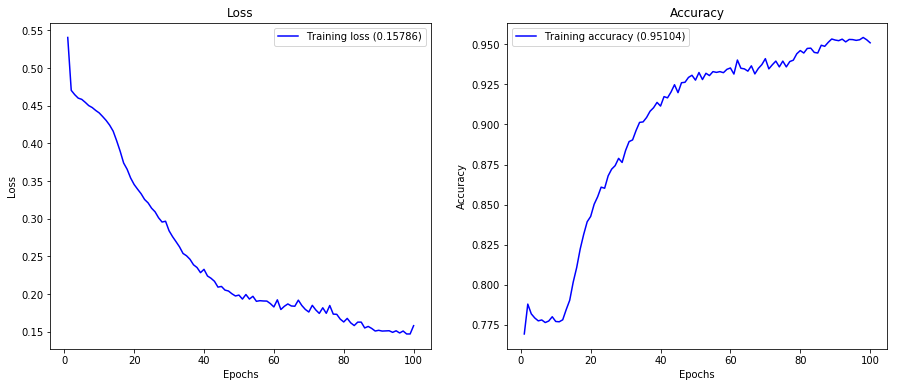

In [19]:
import tensorflow as tf
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import cross_val_score
from keras.models import Sequential # initialize neural network library
from keras.layers import Dense # build our layers library

run_ANN1 = True

if run_ANN1:
    def build_classifier():
        classifier = Sequential() # initialize neural network
        classifier.add(Dense(units = 20, kernel_initializer = 'uniform', activation = 'relu', input_dim = X_train.shape[1]))
        classifier.add(Dense(units = 10, kernel_initializer = 'uniform', activation = 'relu'))
        classifier.add(Dense(units = 1, kernel_initializer = 'uniform', activation = 'sigmoid'))
        classifier.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])
        return classifier
    classifier = KerasClassifier(build_fn = build_classifier, epochs = 100).fit(x = X_train, y = y_train, batch_size = 100)

    plot_history(classifier)

The previous plot shows how the accuracy of the neural newtork varies over the course of training. Although the neural network model performs well, it is not as accurate as our models based on decision trees.

# Can you beat the best model?

Our random forest model performed the best with respect to accuracy. In this section, you can test your own intuition against this model. The following code block defines and fits the random forest classifier.

In [20]:
RFclf = RandomForestClassifier(n_estimators=100, random_state=0)
RFclf = RFclf.fit(X_train, y_train)

The following code block regenerates the interactive plot that shows how the number of employees that left their job change as the various attributes accounted for in the dataset vary.

In [21]:
attribute_columns = ['satisfaction_level', 'last_evaluation', 'number_of_projects',
                     'average_monthly_hours', 'years_with_company', 'involved_in_accident', 'promoted_last_5_years', 'department', 'salary_level']

@interact(attribute = attribute_columns)

def interactive_spend_analysis(attribute = attribute_columns[0]):
    
    data_copy = data.copy()
    data_copy['satisfaction_level'] = pd.cut(data_copy['satisfaction_level'], [i*10 for i in range(11)])
    data_copy['last_evaluation'] = pd.cut(data_copy['last_evaluation'], [i*10 for i in range(11)])
    data_copy['average_monthly_hours'] = pd.cut(data_copy['average_monthly_hours'], [i*25 for i in range(3,14)])
    
    fig, ax = plt.subplots(figsize=(12, 6))
    sns.countplot(x = attribute, 
                  data = data_copy, 
                  hue = 'left_company', 
                  ax = ax,
                  edgecolor = 'k')
    plt.xticks(rotation = 45, fontsize = 14)
    plt.yticks(fontsize = 14)
    ax.set_xlabel(attribute, fontsize = 16)
    ax.set_ylabel('Count', fontsize = 16)
    plt.legend(title ='left_company',fontsize = 16)
    
    plt.show()

interactive(children=(Dropdown(description='attribute', options=('satisfaction_level', 'last_evaluation', 'num…

The following code block allows you to specify an integer between 0 and 4499, where each value corresponds to a particular instance in the testing dataset. Running the cell will print the values for the various attributes (or features) in the data. Using this data, along with the previous plot, you can determine your prediction fro whether the associated employee stayed with the company of left.

In [22]:
instance = 9 # max 4499 (9, 0, 22, 1, 8)

for i in range(len(features)):
    print(f'{features[i]}: {np.array(X_test)[instance,i]}')

satisfaction_level: 16.0
last_evaluation: 90.0
number_of_projects: 5.0
average_monthly_hours: 258.0
years_with_company: 3.0
involved_in_accident: 0.0
promoted_last_5_years: 0.0
IT: 0.0
RandD: 0.0
accounting: 0.0
hr: 0.0
management: 0.0
marketing: 0.0
product_mng: 0.0
sales: 0.0
support: 0.0
technical: 1.0
salary_high: 0.0
salary_low: 0.0
salary_medium: 1.0


The following code block checks whether or not the random forest classifier correctly predicts whether the employee stayed or left for the specified instance.

In [23]:
pred = int(RFclf.predict(np.array(X_test)[instance,:].reshape(1,-1)))
actual = np.array(y_test)[instance]

if (pred == 1) & (actual == 1):
    print('The random forest correctly predicts that the employee left.')
if (pred == 0) & (actual == 0):
    print('The random forest correctly predicts that the employee did not leave.')
if (pred == 1) & (actual == 0):
    print('The random forest predicts that the employee left, but they did not.')
if (pred == 0) & (actual ==1):
    print('The random forest predicts that the employee did not leave, but they did.')

The random forest correctly predicts that the employee did not leave.
